In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`pip install numpy, matplotlib, networkx`

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [3]:
from collections import defaultdict

`pip install python-louvain`

In [4]:
import community as pylouvain

**IMPORTANT**
To compile the Cython code of modsoft :
- `pip install Cython`
- Go to the modsoft directory
- Do: `python setup.py build_ext --inplace`

In [5]:
import modsoft

# Utils

In [6]:
def plot_communities(graph, pos, membership, figsize=(10, 10)):
    fig = plt.figure(figsize=figsize)
    ax = plt.axes([0, 0, 1, 1])
    ax.set_aspect('equal')
    nx.draw_networkx_edges(graph, pos, ax=ax)

    plt.xlim(-0.1, 1.1)
    plt.ylim(-0.1, 1.1)

    trans = ax.transData.transform
    trans2 = fig.transFigure.inverted().transform

    pie_size = 0.05
    p2 = pie_size / 2.0
    for node in graph:
        xx, yy = trans(pos[node])   # figure coordinates
        xa, ya = trans2((xx, yy))   # axes coordinates
        a = plt.axes([xa - p2, ya - p2, pie_size, pie_size])
        a.set_aspect('equal')
        fractions = membership[node]
        a.pie(fractions)
    plt.show()

# Generate graph

In [7]:
def stochastic_block_model(membership_matrix, connectivity_matrix):
    n_nodes, n_coms = membership_matrix.shape
    parameters = np.matmul(membership_matrix, np.matmul(connectivity_matrix, membership_matrix.T))
    graph = nx.Graph()
    graph.add_nodes_from(range(n_nodes))
    for i in range(n_nodes):
        for j in range(i + 1, n_nodes):
            if random.random() < parameters[i, j]:
                graph.add_edge(i, j)
    return graph


def two_params_stochastic_block_model(community_sizes, din, dout):
    n_nodes = sum(community_sizes)
    n_coms = len(community_sizes)
    community_sizes = np.array(community_sizes)
    index = np.cumsum(community_sizes)
    communities = list()
    membership_matrix = np.zeros((n_nodes, n_coms))
    for k in range(n_coms):
        community = list((index[k - 1] % n_nodes) + range(community_sizes[k]))
        communities.append(community)
        membership_matrix[community, k] = 1
    connectivity_out = 1. * dout * n_nodes / (n_nodes * n_nodes - sum(community_sizes * community_sizes))
    connectivity_matrix = connectivity_out * np.ones((n_coms, n_coms))
    for k in range(n_coms):
        connectivity_matrix[k, k] = 1. * din / (community_sizes[k] - 1)
    graph = stochastic_block_model(membership_matrix, connectivity_matrix)
    return graph, communities, membership_matrix

In [8]:
com_size = 10
overlap_size = 2
n_communities = 3
pin = 0.95
pout = 0.05

In [9]:
gt_membership_matrix = np.zeros((n_communities * com_size - (n_communities - 1) * overlap_size,
                                 n_communities))
for i in range(n_communities):
    index = i * com_size - i * overlap_size
    gt_membership_matrix[index:(index + com_size), i] = 1.

In [10]:
gt_connectivity_matrix = pout * np.ones((n_communities, n_communities))
np.fill_diagonal(gt_connectivity_matrix, pin)

In [11]:
graph = stochastic_block_model(gt_membership_matrix, gt_connectivity_matrix)

In [12]:
adj_matrix = nx.adj_matrix(graph)

In [13]:
true_communities = [np.where(gt_membership_matrix[:, i])[0] for i in range(gt_membership_matrix.shape[1])]
true_communities = map(set, true_communities)

In [14]:
pos = nx.fruchterman_reingold_layout(graph, center=[.5, .5], scale=.5)

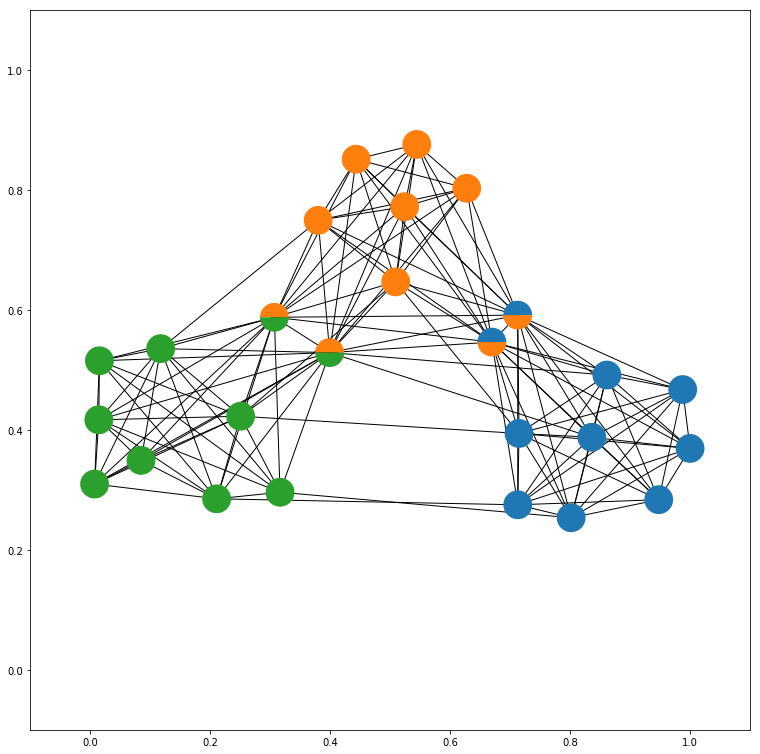

In [15]:
plot_communities(graph, pos, gt_membership_matrix)

# Louvain

In [16]:
%%time
louvain_part = pylouvain.best_partition(graph)

CPU times: user 5.66 ms, sys: 1.51 ms, total: 7.18 ms
Wall time: 5.93 ms


In [17]:
louvain_communities = defaultdict(set)
for node in graph:
    louvain_communities[louvain_part[node]].add(node)
louvain_communities = louvain_communities.values()
louvain_membership = np.zeros((graph.number_of_nodes(), len(louvain_communities)))
for k, community in enumerate(louvain_communities):
    for i in community:
        louvain_membership[i, k] = 1.

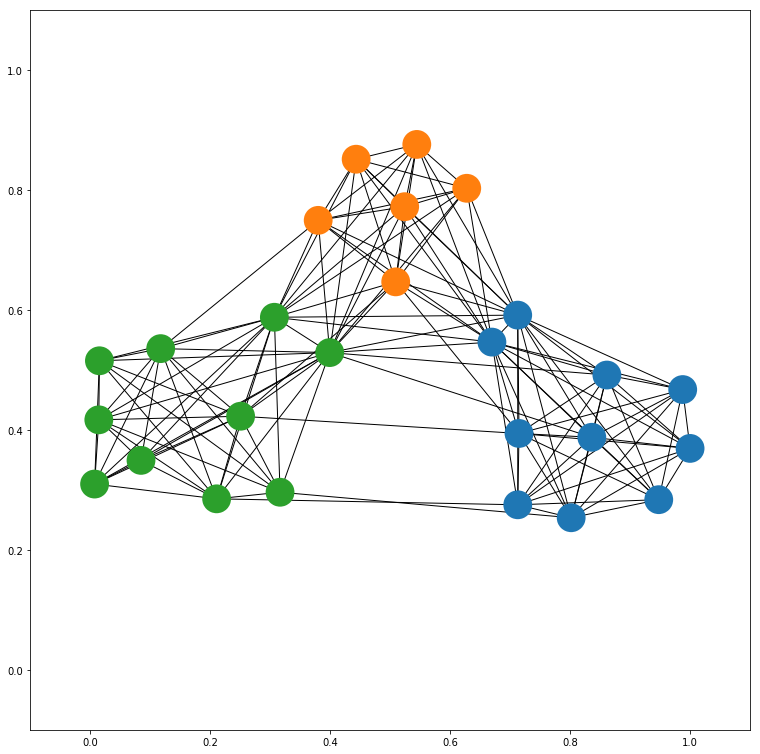

In [18]:
plot_communities(graph, pos, louvain_membership)

# Modsoft

In [19]:
learning_rate=.7

In [20]:
max_n_epochs = 15
epsilon = 1e-4

The graph can be given as a NetworkX object or a Scipy Sparse CSR matrix.

In [21]:
ms = modsoft.get_modsoft_object(graph, learning_rate=learning_rate)

In [22]:
%%time
modsoft_mod = ms.modularity()
for i in range(max_n_epochs):
    ms.one_step()
    new_modsoft_mod = ms.modularity()
    if abs(new_modsoft_mod - modsoft_mod) < epsilon:
        break
    else:
        modsoft_mod = new_modsoft_mod
modsoft_mod = ms.modularity()

CPU times: user 1.69 ms, sys: 34 µs, total: 1.73 ms
Wall time: 1.72 ms


In [23]:
modsoft_mod

0.3807631717460619

In [24]:
modsoft_membership = ms.get_membership()

In [25]:
modsoft_community_indices = set()
for membership in modsoft_membership:
    modsoft_community_indices |= set(membership.keys())
modsoft_community_indices = list(modsoft_community_indices)
modsoft_community_indices_inv = {index: i for i, index in enumerate(modsoft_community_indices)}
modsoft_membership_mat = np.zeros((adj_matrix.shape[0], len(modsoft_community_indices)))
for i in range(adj_matrix.shape[0]):
    for community in modsoft_membership[i]:
        modsoft_membership_mat[i][modsoft_community_indices_inv[community]] = modsoft_membership[i][community]

In [26]:
modsoft_membership

[{6: 1.0},
 {6: 1.0},
 {6: 1.0},
 {6: 1.0},
 {6: 1.0},
 {6: 1.0},
 {6: 1.0},
 {6: 1.0},
 {6: 0.6635992260921775, 15: 0.3364007739078225},
 {6: 0.6614886913835023, 15: 0.3385113086164977},
 {15: 1.0},
 {15: 1.0},
 {15: 1.0},
 {15: 1.0},
 {15: 1.0},
 {15: 1.0},
 {15: 0.27481602264273497, 24: 0.725183977357265},
 {15: 0.29827453722983455, 24: 0.7017254627701655},
 {24: 1.0},
 {24: 1.0},
 {24: 1.0},
 {24: 1.0},
 {24: 1.0},
 {24: 1.0},
 {24: 1.0},
 {24: 1.0}]

In [27]:
np.round(modsoft_membership_mat, 4)

array([[0.    , 1.    , 0.    ],
       [0.    , 1.    , 0.    ],
       [0.    , 1.    , 0.    ],
       [0.    , 1.    , 0.    ],
       [0.    , 1.    , 0.    ],
       [0.    , 1.    , 0.    ],
       [0.    , 1.    , 0.    ],
       [0.    , 1.    , 0.    ],
       [0.    , 0.6636, 0.3364],
       [0.    , 0.6615, 0.3385],
       [0.    , 0.    , 1.    ],
       [0.    , 0.    , 1.    ],
       [0.    , 0.    , 1.    ],
       [0.    , 0.    , 1.    ],
       [0.    , 0.    , 1.    ],
       [0.    , 0.    , 1.    ],
       [0.7252, 0.    , 0.2748],
       [0.7017, 0.    , 0.2983],
       [1.    , 0.    , 0.    ],
       [1.    , 0.    , 0.    ],
       [1.    , 0.    , 0.    ],
       [1.    , 0.    , 0.    ],
       [1.    , 0.    , 0.    ],
       [1.    , 0.    , 0.    ],
       [1.    , 0.    , 0.    ],
       [1.    , 0.    , 0.    ]])

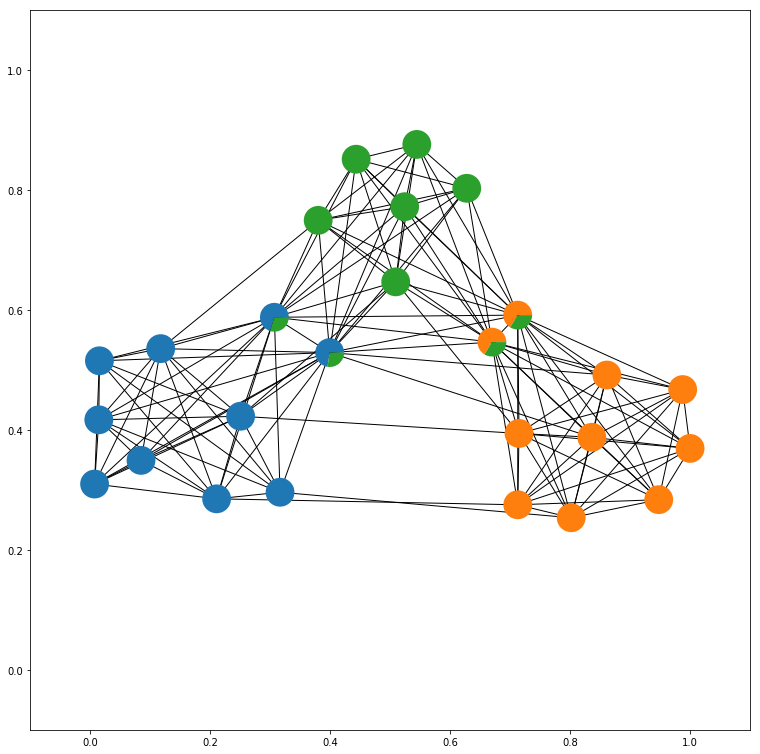

In [28]:
plot_communities(graph, pos, modsoft_membership_mat)

# Modsoft with Louvain initialization

In [29]:
max_n_epochs = 15
epsilon = 1e-5

In [30]:
learning_rate = .4
bias = 0.

In [31]:
init_part = np.array([louvain_part[node] for node in graph.nodes()])

In [32]:
ms = modsoft.get_modsoft_object(adj_matrix,
                                init_part=init_part,
                                learning_rate=learning_rate, bias=bias)

In [33]:
%%time
modsoft_mod = ms.modularity()
for i in range(max_n_epochs):
    ms.one_step()
    new_modsoft_mod = ms.modularity()
    if abs(new_modsoft_mod - modsoft_mod) < epsilon:
        break
    else:
        modsoft_mod = new_modsoft_mod
modsoft_mod = ms.modularity()

CPU times: user 842 µs, sys: 14 µs, total: 856 µs
Wall time: 853 µs


In [34]:
modsoft_membership = ms.get_membership()

In [35]:
modsoft_community_indices = set()
for membership in modsoft_membership:
    modsoft_community_indices |= set(membership.keys())
modsoft_community_indices = list(modsoft_community_indices)
modsoft_community_indices_inv = {index: i for i, index in enumerate(modsoft_community_indices)}
modsoft_membership_mat = np.zeros((adj_matrix.shape[0], len(modsoft_community_indices)))
for i in range(adj_matrix.shape[0]):
    for community in modsoft_membership[i]:
        modsoft_membership_mat[i][modsoft_community_indices_inv[community]] = modsoft_membership[i][community]

In [36]:
modsoft_membership

[{0: 1.0},
 {0: 1.0},
 {0: 1.0},
 {0: 1.0},
 {0: 1.0},
 {0: 1.0},
 {0: 1.0},
 {0: 1.0},
 {0: 0.608769675726766, 1: 0.391230324273234},
 {0: 0.608807352171048, 1: 0.391192647828952},
 {1: 1.0},
 {1: 1.0},
 {1: 1.0},
 {1: 1.0},
 {1: 1.0},
 {1: 1.0},
 {1: 0.3537539078412735, 2: 0.6462460921587265},
 {1: 0.34140146261316073, 2: 0.6585985373868393},
 {2: 1.0},
 {2: 1.0},
 {2: 1.0},
 {2: 1.0},
 {2: 1.0},
 {2: 1.0},
 {2: 1.0},
 {2: 1.0}]

In [37]:
np.round(modsoft_membership_mat, 4)

array([[1.    , 0.    , 0.    ],
       [1.    , 0.    , 0.    ],
       [1.    , 0.    , 0.    ],
       [1.    , 0.    , 0.    ],
       [1.    , 0.    , 0.    ],
       [1.    , 0.    , 0.    ],
       [1.    , 0.    , 0.    ],
       [1.    , 0.    , 0.    ],
       [0.6088, 0.3912, 0.    ],
       [0.6088, 0.3912, 0.    ],
       [0.    , 1.    , 0.    ],
       [0.    , 1.    , 0.    ],
       [0.    , 1.    , 0.    ],
       [0.    , 1.    , 0.    ],
       [0.    , 1.    , 0.    ],
       [0.    , 1.    , 0.    ],
       [0.    , 0.3538, 0.6462],
       [0.    , 0.3414, 0.6586],
       [0.    , 0.    , 1.    ],
       [0.    , 0.    , 1.    ],
       [0.    , 0.    , 1.    ],
       [0.    , 0.    , 1.    ],
       [0.    , 0.    , 1.    ],
       [0.    , 0.    , 1.    ],
       [0.    , 0.    , 1.    ],
       [0.    , 0.    , 1.    ]])

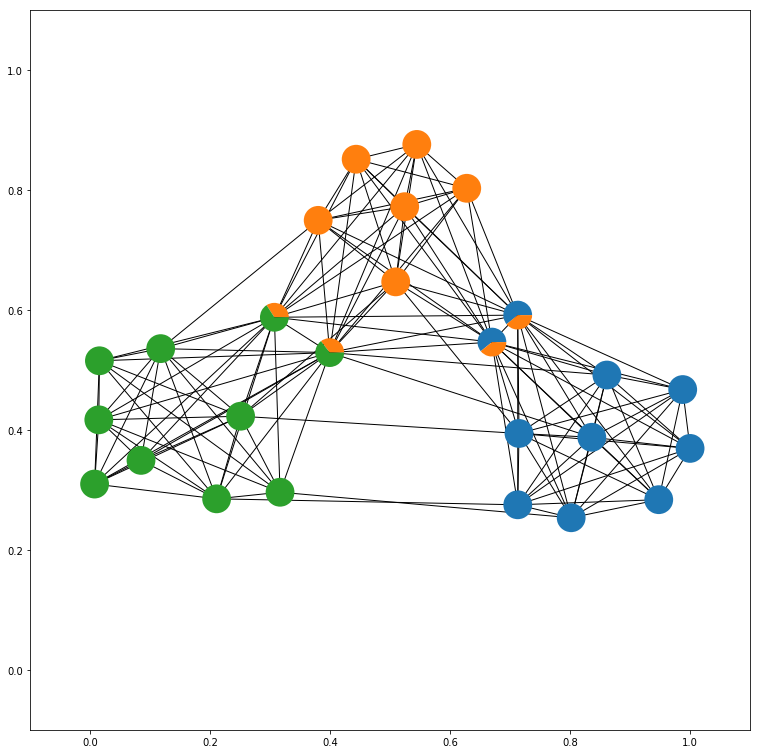

In [38]:
plot_communities(graph, pos, modsoft_membership_mat)